# Vocal Separation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import xgboost as xgb

In [3]:
import soundfile as sf

In [5]:
import pandas as pd

In [6]:
import os
path = "IRMAS-Sample/Training" #文件夹目录
files= os.listdir(path)

In [7]:
def fileFolder2FeatureTable(instrument_type, path):
    rootpath = path +'/' +instrument_type
    files = os.listdir(rootpath)
    df_total = pd.DataFrame()
    for i in files:
        y, sr = librosa.load(rootpath+'/'+i)
        m_slaney = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40, dct_type=2)
        #m_htk = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40, dct_type=3)
        single_df = pd.DataFrame(m_slaney.T)
        single_df['label'] = instrument_type
        df_total = pd.concat([df_total, single_df])
    df_total = df_total.reset_index(drop =True)
    return (df_total)

In [7]:
def keys_of_value(dct, value):
    for k in dct:
        if isinstance(dct[k], list):
            if value in dct[k]:
                return k
        else:
            if value == dct[k]:
                return k

In [8]:
instru_dict = {"voi":10, "vio":9, "tru":8, "sax":7, "pia":6, "org":5, "gel":4, "gac":3, "flu":2, "cla":1, "cel":0}

In [11]:
keys_of_value(instru_dict, 9)

'vio'

In [31]:
#输入单乐器乐曲，得到其乐器的得分
from collections import Counter
def musicFile2FeatureTable(file_path):
    txt_path = file_path[:-3]+'txt'
    music_class = open(txt_path)
    instrument_type_true = music_class.read()
    print('the instrument is %s'%instrument_type_true)
    y, sr = librosa.load(file_path)
    m_slaney = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40, dct_type=2)
    single_df = pd.DataFrame(m_slaney.T)
    bst = xgb.Booster({'nthread':4}) #init model
    bst.load_model("xgboost.model.txt")
    result = bst.predict(xgb.DMatrix(single_df))
    predictions = []
    for x in result:
        predictions.append(np.argmax(x))
    counter_words = Counter(predictions)
    most_counter = counter_words.most_common(1)
    return(keys_of_value(instru_dict, most_counter[0][0]))

In [9]:
#输入多乐器乐曲，得到其乐器的得分
from collections import Counter
def multiMusicFile2Score(file_path, bst, threshold_score = 0.1, time_threshold = 0.3):
    txt_path = file_path[:-3]+'txt'
    music_class = open(txt_path)
    instrument_type_true = music_class.read()
    #print('the true instrument of file is \n%s'%instrument_type_true)
    y, sr = librosa.load(file_path)
    m_slaney = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40, dct_type=2)
    single_df = pd.DataFrame(m_slaney.T)
    result = bst.predict(xgb.DMatrix(single_df))
    predictions = []
    return_pred= []
    for x in result:
        for i in range(len(x)):
            if (x[i] >threshold_score):
                predictions.append(i)
    counter_words = Counter(predictions)
    most_counter = counter_words.most_common(5)
    for j in most_counter:
        if (j[1] > time_threshold*len(result)):
            return_pred.append((keys_of_value(instru_dict, j[0])))
    return(return_pred)
    #return(keys_of_value(instru_dict, most_counter[0][0]))

In [11]:
#输入多乐器乐曲，得到其XGBoost打分矩阵
def multiMusicFile2probTable(file_path, bst):
    y, sr = librosa.load(file_path)
    m_slaney = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40, dct_type=2)
    single_df = pd.DataFrame(m_slaney.T)
    result = bst.predict(xgb.DMatrix(single_df))
    return(result)

In [16]:
#得到各个打分矩阵和标签
%%time
result_total_list = []
true_total_list = []
rootpath = 'IRMAS-TestingData-Part1/Part1'
bst = xgb.Booster({'nthread':4}) #init model
bst.load_model("xgboost.model.txt")
files = os.listdir(rootpath)
for i in files:
    filepath = rootpath+'/'+i
    if (filepath[-3:] == 'wav'):
        single_prediction_table= multiMusicFile2probTable(filepath, bst)
        result_total_list.append(single_prediction_table)
        txt_path = filepath[:-3]+'txt'
        music_class = open(txt_path)
        instrument_type_true = list(filter(None, music_class.read().split('\t\n')))
        true_total_list.append(instrument_type_true)

CPU times: user 47min 41s, sys: 34.5 s, total: 48min 15s
Wall time: 48min 3s


In [22]:
#grid search 适合多乐器打分的参数
%%time
# rootpath = 'IRMAS-TestingData-Part1/Part1'
# bst = xgb.Booster({'nthread':4}) #init model
# bst.load_model("xgboost.model.txt")
# files = os.listdir(rootpath)
threshold_score = [0.2, 0.25, 0,3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
time_threshold = [0.3, 0.4, 0.45, 0.5, 0.55]
accuracy_best = 0
for single_score in threshold_score:
    for single_time_score in time_threshold:
        total_file = 0
        prediction_true_file = 0
        for i in range(len(result_total_list)):
            pred_instru = []
            predictions = []
            for x in result_total_list[i]:
                for k in range(len(x)):
                    if (x[k] > single_score):
                        predictions.append(k)
            counter_words = Counter(predictions)
            most_counter = counter_words.most_common(5)
            for j in most_counter:
                if (j[1] > single_time_score*len(x)):
                    pred_instru.append((keys_of_value(instru_dict, j[0])))
            if (set(pred_instru) == set(true_total_list[i])):
                prediction_true_file +=1
            total_file +=1
        accuracy = prediction_true_file/total_file
        if (accuracy > accuracy_best):
            accuracy_best = accuracy
            print('parameter is:', single_score, single_time_score)
            print('accuracy for this time: ', accuracy_best)        
#         for i in files:
#             filepath = rootpath+'/'+i
#             if (filepath[-3:] == 'wav'):
#                 prediction_instrument = multiMusicFile2Score(filepath, bst, single_score, single_time_score)
#                 #print('prediction is \n', prediction_instrument)
#                 txt_path = filepath[:-3]+'txt'
#                 music_class = open(txt_path)
#                 instrument_type_true = list(filter(None, music_class.read().split('\t\n')))
#                 if (set(prediction_instrument) == set(instrument_type_true)):
#                     prediction_true_file +=1
#                 total_file +=1
#         accuracy = prediction_true_file/total_file
#         if (accuracy > accuracy_best):
#             accuracy_best = accuracy
#             print('parameter is:', single_score, single_time_score)
#             print('accuracy for this time: ', accuracy_best)

parameter is: 0.2 0.3
accuracy for this time:  0.0024783147459727386
parameter is: 0.2 0.4
accuracy for this time:  0.0037174721189591076
parameter is: 0.25 0.4
accuracy for this time:  0.004956629491945477
parameter is: 0.25 0.5
accuracy for this time:  0.006195786864931847
parameter is: 0.25 0.55
accuracy for this time:  0.007434944237918215
parameter is: 0.35 0.3
accuracy for this time:  0.01734820322180917
parameter is: 0.35 0.4
accuracy for this time:  0.01982651796778191
parameter is: 0.35 0.5
accuracy for this time:  0.026022304832713755
parameter is: 0.35 0.55
accuracy for this time:  0.028500619578686492
parameter is: 0.4 0.4
accuracy for this time:  0.03345724907063197
parameter is: 0.4 0.5
accuracy for this time:  0.03593556381660471
parameter is: 0.4 0.55
accuracy for this time:  0.04337050805452292
parameter is: 0.45 0.4
accuracy for this time:  0.05080545229244114
parameter is: 0.45 0.5
accuracy for this time:  0.061957868649318466
parameter is: 0.45 0.55
accuracy for thi

In [23]:
#输入多乐器乐曲和乐器数量，进行预测
def multiMusicExactPrediction(file_path, bst, instrument_num, threshold_score =0.3):
    y, sr = librosa.load(file_path)
    m_slaney = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40, dct_type=2)
    single_df = pd.DataFrame(m_slaney.T)
    result = bst.predict(xgb.DMatrix(single_df))
    return_pred = []
    predictions = []
    for x in result:
        for i in range(len(x)):
            if (x[i] >threshold_score):
                predictions.append(i)
    counter_words = Counter(predictions)
    most_counter = counter_words.most_common(instrument_num)
    for j in most_counter:
        return_pred.append((keys_of_value(instru_dict, j[0])))
    return(return_pred)

In [51]:
multiMusicExactPrediction('IRMAS-TestingData-Part1/Part1/02 - Bo-Do-10.wav', bst, 2)

['pia', 'flu']

In [55]:
int("3")

3

In [30]:
def multiMusicExactPredictionforTestingData(file_path, bst, threshold_score =0.3):
    txt_path = filepath[:-3]+'txt'
    music_class = open(txt_path)
    instrument_type_true = list(filter(None, music_class.read().split('\t\n')))
    instrument_num = len(instrument_type_true)
    print('true type is:\n', instrument_type_true)
    y, sr = librosa.load(file_path)
    m_slaney = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40, dct_type=2)
    single_df = pd.DataFrame(m_slaney.T)
    result = bst.predict(xgb.DMatrix(single_df))
    return_pred = []
    predictions = []
    for x in result:
        for i in range(len(x)):
            if (x[i] >threshold_score):
                predictions.append(i)
    counter_words = Counter(predictions)
    most_counter = counter_words.most_common(instrument_num)
    for j in most_counter:
        return_pred.append((keys_of_value(instru_dict, j[0])))
    return(return_pred)

In [31]:
multiMusicExactPredictionforTestingData('IRMAS-TestingData-Part1/Part1/02 - Bo-Do-10.wav', bst)

true type is:
 ['pia', 'voi']


['pia', 'flu']

In [52]:
def multiMusicExactPredictionforTestingDataArgMax(file_path, bst, threshold_score =0.3):
    txt_path = filepath[:-3]+'txt'
    music_class = open(txt_path)
    instrument_type_true = list(filter(None, music_class.read().split('\t\n')))
    instrument_num = len(instrument_type_true)
    print('true type is:\n', instrument_type_true)
    y, sr = librosa.load(file_path)
    m_slaney = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40, dct_type=2)
    single_df = pd.DataFrame(m_slaney.T)
    result = bst.predict(xgb.DMatrix(single_df))
    return_pred = []
    predictions = []
    for x in result:
        predictions.append(np.argmax(x))
    counter_words = Counter(predictions)
    most_counter = counter_words.most_common(instrument_num)
    for j in most_counter:
        return_pred.append((keys_of_value(instru_dict, j[0])))
    return(return_pred)

In [53]:
multiMusicExactPredictionforTestingDataArgMax('IRMAS-TestingData-Part1/Part1/02 - Bo-Do-10.wav', bst)

true type is:
 ['pia', 'voi']


['flu', 'pia']

In [50]:
#对给定乐器数量情况下的预测准确率作为标准进行建模和调参
threshold_score_list = [0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6]
accuracy_best = 0
for single_threshold in threshold_score_list:
    total_file = 0
    prediction_true_file = 0
    for i in range(len(result_total_list)):
        pred_instru = []
        predictions = []
        for x in result_total_list[i]:
            for k in range(len(x)):
                if (x[k] > single_score):
                    predictions.append(k)
        counter_words = Counter(predictions)
        most_counter = counter_words.most_common(len(true_total_list[i]))
        for j in most_counter:
            pred_instru.append((keys_of_value(instru_dict, j[0])))
        if (set(pred_instru) == set(true_total_list[i])):
            prediction_true_file +=1
        total_file +=1
    accuracy = prediction_true_file/total_file
    if (accuracy > accuracy_best):
        accuracy_best = accuracy
        print('parameter is:', single_threshold)
        print('accuracy for this time: ', accuracy_best)        

parameter is: 0.1
accuracy for this time:  0.29739776951672864


In [49]:
#对给定乐器数量情况下的预测准确率
accuracy_best = 0
total_file = 0
prediction_true_file = 0
for i in range(len(result_total_list)):
    pred_instru = []
    predictions = []
    for x in result_total_list[i]:
        predictions.append(np.argmax(x))
    counter_words = Counter(predictions)
    most_counter = counter_words.most_common(len(true_total_list[i]))
    for j in most_counter:
        pred_instru.append((keys_of_value(instru_dict, j[0])))
    if (set(pred_instru) == set(true_total_list[i])):
        prediction_true_file +=1
    total_file +=1
accuracy = prediction_true_file/total_file
if (accuracy > accuracy_best):
    accuracy_best = accuracy
    print('accuracy for this time: ', accuracy_best)        

accuracy for this time:  0.33705080545229243


In [45]:
for x in result_total_list[1]:
    
    for k in x:
        print(k)
        predictions.append(np.argmax(k))
    counter_words = Counter(predictions)
    most_counter = counter_words.most_common(len(true_total_list[i]))

0.0024170142
0.04536348
0.022874342
0.009215046
0.121836536
0.32817173
0.21302487
0.10536988
0.037614726
0.03568371
0.078428656
0.001448885
0.00622488
0.031906493
0.015717002
0.08189808
0.51799405
0.0748946
0.13623652
0.03417639
0.016401306
0.08310182
0.0022223815
0.011584244
0.03357956
0.05666539
0.07867298
0.47297928
0.0405599
0.14527199
0.051651783
0.024658112
0.08215436
0.0030513243
0.010065106
0.0359434
0.08550324
0.13780566
0.22742157
0.0862329
0.1925375
0.07155144
0.038714223
0.111173585
0.0023901623
0.006284514
0.06424775
0.054096222
0.080186546
0.19630846
0.14666526
0.22142501
0.07520854
0.0635336
0.08965387
0.0020464289
0.0050009387
0.056342017
0.046758726
0.09384081
0.21721514
0.122688815
0.17490143
0.03710461
0.115735844
0.12836526
0.0038875465
0.011111549
0.06397738
0.013066747
0.0859481
0.24589026
0.23559247
0.12542357
0.05137689
0.11300025
0.050725248
0.0025375127
0.00986006
0.06117663
0.023014313
0.07790884
0.26289895
0.15109025
0.15688814
0.06990221
0.13612135
0.048601

0.096351124
0.006505866
0.08139617
0.010662162
0.02103542
0.069681704
0.010482975
0.05104898
0.51537645
0.057694122
0.024445303
0.078206845
0.025284775
0.13608128
0.004879547
0.04701002
0.04191147
0.00233883
0.032292318
0.6479728
0.10665504
0.008163716
0.037930768
0.036954246
0.033891216
0.0039676917
0.06741258
0.040533908
0.0004718473
0.013652397
0.77105826
0.04937226
0.008054016
0.020380722
0.01837931
0.0067170397
0.0040888214
0.034870233
0.018370152
0.0005329175
0.005819589
0.90085554
0.014164756
0.0032675103
0.008852598
0.005240691
0.0039372537
0.0013294129
0.014489172
0.015271913
0.004951083
0.032072917
0.8426334
0.0047039185
0.0044332235
0.011718347
0.0062552616
0.062141314
0.019653026
0.015729437
0.026392523
0.05653133
0.15501648
0.34086284
0.01996137
0.035338517
0.05790437
0.021487558
0.2511225
0.025019137
0.014651647
0.024523165
0.040086284
0.19088611
0.29381067
0.025377953
0.05243382
0.07700754
0.019469548
0.2367341
0.019119002
0.009964738
0.039562
0.056202553
0.10922094
0.41

0.8656807
0.011348488
0.00599199
0.014871872
0.013623004
0.0019230056
0.0015851881
0.027345747
0.020797927
0.00020085394
0.0023409415
0.90752405
0.006967724
0.0035883738
0.01604094
0.012392239
0.0012160094
0.004537931
0.085411906
0.038251445
0.0005438298
0.0044516795
0.7953752
0.022391418
0.0059904126
0.024124952
0.016439738
0.0024814573
0.0026185715
0.10209555
0.024787605
0.0008688615
0.009318173
0.76170266
0.029783053
0.0060991817
0.038664747
0.017506108
0.0065554627
0.0021205314
0.03503672
0.035857923
0.0011718775
0.013310659
0.7495001
0.0714564
0.009585118
0.038184676
0.03329406
0.010481952
0.002375765
0.029110342
0.061281182
0.0026050492
0.018363738
0.5881407
0.14660965
0.014719617
0.06794231
0.046166267
0.022685403
0.0042202417
0.0279916
0.05113887
0.0029347718
0.016908986
0.42217755
0.2988003
0.02270796
0.046882764
0.08715162
0.019085292
0.008465433
0.030298797
0.08294079
0.0032492892
0.019907333
0.43463323
0.20773987
0.025127906
0.0721914
0.09033595
0.025109971
0.018575963
0.02

0.0069263037
0.021577142
0.078088015
0.0011377247
0.016508782
0.73862255
0.04453406
0.01559113
0.03166758
0.009330832
0.036015898
0.018924775
0.06101759
0.09915774
0.0024553924
0.015738185
0.655373
0.040148832
0.016370848
0.03437577
0.029590491
0.026847426
0.049647655
0.104518846
0.1759347
0.0033555166
0.02265308
0.43087658
0.02634243
0.018059723
0.07153118
0.0713666
0.02571367
0.02253309
0.031038135
0.07836838
0.0025664016
0.0076925266
0.6737286
0.020093665
0.017788667
0.10499605
0.02932325
0.011871245
0.0058302344
0.025182804
0.049779236
0.0010092087
0.0026673735
0.7732355
0.009884986
0.01833774
0.09291959
0.013774708
0.0073785568
0.013774748
0.123573355
0.08483522
0.0013785767
0.00391182
0.48421866
0.02295291
0.052303243
0.16029918
0.036857285
0.015895013
0.016191032
0.24889682
0.064246744
0.0011457073
0.0040378487
0.38040468
0.02519219
0.049187254
0.14402123
0.059027754
0.007648733
0.015807657
0.23158471
0.075082324
0.0005974064
0.0018179739
0.48279715
0.015536444
0.037889525
0.111

0.0017764353
0.032542728
0.044625234
0.014361048
0.027229792
0.016545061
0.031107226
0.77380246
0.020430325
0.0068968297
0.010607516
0.0009869379
0.03763129
0.039284475
0.012804567
0.0210971
0.0051034475
0.019884266
0.8252733
0.0070546577
0.02261946
0.010211576
0.0021236131
0.069375105
0.023296896
0.017736947
0.026576284
0.004407793
0.017517963
0.79907966
0.0071571236
0.020519309
0.014459103
0.003636934
0.04365453
0.018667428
0.015217846
0.03308304
0.005759453
0.015902026
0.8219432
0.0091574015
0.026156101
0.02960572
0.015682463
0.25978753
0.07301583
0.028660225
0.052448917
0.017198654
0.07717145
0.4111157
0.006350926
0.011691651
0.076126575
0.059294228
0.16489156
0.15718143
0.031005884
0.059631288
0.02451463
0.06558594
0.3437259
0.009863867
0.010811339
0.09253813
0.06570161
0.120061785
0.13756037
0.059067383
0.062299345
0.05952543
0.067220904
0.31534985
0.010252748
0.008217747
0.11393551
0.120886475
0.1004397
0.11729332
0.035834588
0.050279126
0.03158887
0.072087474
0.33918446
0.00549

0.13369048
0.313758
0.090386964
0.049997296
0.07364912
0.1463769
0.07761857
0.001987557
0.0042859316
0.09433049
0.016791882
0.08877621
0.5062348
0.048968177
0.02914047
0.099727444
0.04529545
0.06446155
0.0017218385
0.0032984882
0.14554797
0.022271888
0.05587465
0.44614735
0.086355224
0.035136543
0.08458652
0.04332991
0.075729646
0.0014992424
0.0046010297
0.15164992
0.011741762
0.04414689
0.49815604
0.13200891
0.039336402
0.04136979
0.042131707
0.033358335
0.0015447027
0.005991679
0.096861064
0.006187281
0.036491036
0.5135925
0.14051795
0.031192621
0.0774298
0.050254487
0.039936922
0.0013357337
0.0046416926
0.092825405
0.0055341767
0.024043564
0.40631214
0.23922779
0.026603065
0.13064522
0.047299977
0.021531295
0.0024163383
0.0052752267
0.120376505
0.008526493
0.017288651
0.24723016
0.2587112
0.044589657
0.15766487
0.10037659
0.037544325
0.0019484615
0.008471414
0.097861245
0.011251757
0.017748127
0.37713495
0.26140627
0.030114396
0.07773459
0.07770816
0.038620602
0.002091543
0.00625846

0.052758098
0.019902846
0.013621828
0.38785157
0.0073104845
0.11062619
0.06619472
0.0040591992
0.03424533
0.37525135
0.032121968
0.058584914
0.033839066
0.012470216
0.2652966
0.011383997
0.051946234
0.040106013
0.0041379496
0.025946157
0.55719864
0.038594365
0.038568527
0.061414607
0.01541928
0.15528423
0.011082185
0.08672343
0.11253829
0.0055785584
0.035654005
0.35814732
0.041124728
0.0358778
0.029198935
0.015703797
0.26837093
0.010339526
0.08459817
0.075184226
0.0034313882
0.033352412
0.59205675
0.04875326
0.029444259
0.009730211
0.009188057
0.103921704
0.0063299574
0.016854398
0.033995792
0.0010073237
0.012026144
0.80362153
0.020752436
0.013848246
0.022271365
0.009083538
0.060209252
0.038998548
0.018815678
0.09249337
0.0039310423
0.031494673
0.51617074
0.019941218
0.023734072
0.1016669
0.008480766
0.14427303
0.010405607
0.016199324
0.06114745
0.0039700093
0.026698349
0.6235584
0.017035868
0.016703075
0.0608631
0.008787739
0.15463103
0.0047857095
0.008186954
0.043085538
0.0017338155


0.18357134
0.07274388
0.035484925
0.04547174
0.179904
0.0030174903
0.051139317
0.083736256
0.026975723
0.17450662
0.11110484
0.28441054
0.05509611
0.048197225
0.056521114
0.10529478
0.0017628267
0.04050697
0.07972462
0.0226435
0.12040852
0.19138293
0.2830447
0.05550493
0.046818186
0.070389226
0.08781357
0.004774543
0.03935013
0.045370426
0.02413262
0.14889371
0.07467682
0.33087218
0.123361826
0.026584614
0.084966205
0.0970169
0.008590947
0.0273597
0.037260536
0.039023932
0.18224597
0.042840485
0.31276363
0.14625025
0.039889824
0.08169455
0.0820802
0.005439458
0.027977204
0.05633523
0.042929854
0.26151252
0.01621357
0.18381703
0.11537513
0.0517479
0.088005595
0.15064652
0.0036022372
0.036260583
0.05901185
0.050518643
0.1827831
0.03238131
0.21056217
0.11997682
0.0578835
0.06879274
0.17822704
0.011335323
0.021931885
0.073969476
0.053721134
0.143871
0.10440187
0.15740359
0.06638939
0.03860012
0.039056376
0.28931984
0.0069481293
0.022931648
0.024473589
0.052993044
0.2510916
0.085656494
0.14

0.017300101
0.00097268296
0.0067985575
0.86928844
0.014497082
0.0058815293
0.007667775
0.0020322008
0.05333738
0.0011291662
0.013081761
0.008765768
0.0043146433
0.02921288
0.8467811
0.010816435
0.011387086
0.028809024
0.0057262857
0.039975822
0.004603374
0.018933889
0.017053854
0.011534954
0.053169396
0.6749475
0.035801727
0.026118381
0.08150127
0.018381305
0.057954382
0.004906441
0.004882838
0.0043715187
0.00067594013
0.01165317
0.91777325
0.0066566314
0.005369993
0.03272577
0.004161625
0.006822796
0.0007233187
0.0048145154
0.013912515
0.00047916127
0.0042546014
0.90727055
0.00594182
0.019320147
0.02160907
0.0012147493
0.020459529
0.0005137871
0.0036314866
0.007821854
0.00019085102
0.0018995572
0.94578993
0.0050138202
0.007577627
0.015021513
0.0005061654
0.012033374
0.002574367
0.013902153
0.008207913
0.00023193631
0.0016280838
0.9193724
0.012253686
0.011841083
0.015731877
0.0008611006
0.013395445
0.0009911916
0.011286703
0.012480594
0.00024036276
0.0024018048
0.91733956
0.025923314
0

0.09867037
0.07961078
0.061071295
0.027668804
0.041739218
0.20684613
0.0017571484
0.048202742
0.07292776
0.03930257
0.28763294
0.116188705
0.11262787
0.056005143
0.02304429
0.05379685
0.18851396
0.002411547
0.045495033
0.0845346
0.034768492
0.24050267
0.08492617
0.14405192
0.06672064
0.026270026
0.06585374
0.20446514
0.0021619396
0.046410132
0.05705879
0.06540361
0.18016964
0.1214941
0.2581046
0.073495805
0.033941787
0.048804745
0.11295485
0.0016115386
0.034074683
0.043863885
0.04862632
0.18916832
0.13798845
0.2781104
0.078105114
0.040562604
0.026248513
0.12164016
0.0012283263
0.032665916
0.040388275
0.02418122
0.2151322
0.105882175
0.3503138
0.073609345
0.050198246
0.0306329
0.07576761
0.0034705682
0.023656815
0.03670651
0.031795997
0.16823371
0.05580359
0.3465733
0.1487273
0.064797066
0.053520903
0.066714264
0.0039021815
0.03949358
0.07184633
0.058089186
0.16504511
0.04662343
0.30279553
0.103760466
0.052969314
0.07758621
0.077888645
0.0025058605
0.03345293
0.036317296
0.051290687
0.1

In [48]:
np.argmax(result_total_list[0])

4

In [42]:
total_file

807

In [17]:
print(len(result_total_list))
print(len(true_total_list))

807
807


In [15]:
#输入乐曲，得到其中包含几个乐器，并得到分别的MFCC
def instrumentNumForMusic():
    return()

## 用于ml的特征抽取（逐帧）

In [34]:
%%time
voi_raw = fileFolder2FeatureTable('voi','IRMAS-TrainingData')
vio_raw = fileFolder2FeatureTable('vio','IRMAS-TrainingData')
tru_raw = fileFolder2FeatureTable('tru','IRMAS-TrainingData')
sax_raw = fileFolder2FeatureTable('sax','IRMAS-TrainingData')
pia_raw = fileFolder2FeatureTable('pia','IRMAS-TrainingData')
org_raw = fileFolder2FeatureTable('org','IRMAS-TrainingData')
gel_raw = fileFolder2FeatureTable('gel','IRMAS-TrainingData')
gac_raw = fileFolder2FeatureTable('gac','IRMAS-TrainingData')
flu_raw = fileFolder2FeatureTable('flu','IRMAS-TrainingData')
cla_raw = fileFolder2FeatureTable('cla','IRMAS-TrainingData')
cel_raw = fileFolder2FeatureTable('cel','IRMAS-TrainingData')

CPU times: user 5 µs, sys: 8 µs, total: 13 µs
Wall time: 31.9 µs


In [35]:
%%time
raw_data_all = pd.concat([voi_raw, vio_raw, tru_raw, sax_raw, pia_raw, org_raw, gel_raw, gac_raw, flu_raw, cla_raw, cel_raw])
raw_data_all = raw_data_all.reset_index(drop = True)
raw_data_all.to_csv('traindata_raw.csv')

CPU times: user 47.1 s, sys: 1.82 s, total: 48.9 s
Wall time: 50.1 s


In [37]:
raw_data_all.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,label
0,-91.963967,105.096580,-30.380742,19.623144,7.864010,28.667215,9.144874,8.710527,7.943736,3.226403,...,-1.736931,0.362849,6.496445,-2.391663,-11.616247,-9.043096,-7.675692,-5.406505,9.618369,voi
1,-85.366237,101.649270,-33.703561,23.957620,-0.626421,25.965370,3.521350,8.057379,12.864924,2.670274,...,-5.326123,-4.981471,2.376308,-3.255108,-5.930639,-9.866653,-7.677595,0.697900,10.225007,voi
2,-70.602010,96.136897,-44.954211,22.478617,-5.727435,27.195755,4.279557,9.121658,15.989916,4.912378,...,-5.221855,-5.024254,0.142265,-6.889198,-2.167274,-6.240126,-8.406016,1.081667,8.671729,voi
3,-70.923855,100.204938,-48.644282,19.635599,-3.416086,28.776793,8.279170,6.841322,16.674616,4.500598,...,-5.981285,-4.582226,4.517435,-5.094420,-0.759547,-3.510984,-9.008126,-4.384427,5.054848,voi
4,-72.968648,101.455395,-47.118626,16.485796,-4.556425,34.225432,9.645169,2.621069,14.869865,4.898435,...,-7.666123,-7.110345,4.923937,-2.876247,-4.629001,-7.439723,-9.067987,-6.983652,1.462925,voi


In [68]:
raw_data_all.shape

(871650, 41)

In [28]:
instru_dict = {"voi":10, "vio":9, "tru":8, "sax":7, "pia":6, "org":5, "gel":4, "gac":3, "flu":2, "cla":1, "cel":0}

In [38]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(["voi", "vio", "tru", "sax", "pia", "org", "gel", "gac", "flu", "cla", "cel"])

LabelEncoder()

In [70]:
le.transform(["voi", "vio", "tru", "sax", "pia", "org", "gel", "gac", "flu", "cla", "cel"])

array([10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0])

In [44]:
y_all = le.transform(raw_data_all['label'])
x_all = raw_data_all.drop(['label'],axis =1)

In [46]:
x_all.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-91.963967,105.096580,-30.380742,19.623144,7.864010,28.667215,9.144874,8.710527,7.943736,3.226403,...,8.261308,-1.736931,0.362849,6.496445,-2.391663,-11.616247,-9.043096,-7.675692,-5.406505,9.618369
1,-85.366237,101.649270,-33.703561,23.957620,-0.626421,25.965370,3.521350,8.057379,12.864924,2.670274,...,1.882147,-5.326123,-4.981471,2.376308,-3.255108,-5.930639,-9.866653,-7.677595,0.697900,10.225007
2,-70.602010,96.136897,-44.954211,22.478617,-5.727435,27.195755,4.279557,9.121658,15.989916,4.912378,...,-7.804319,-5.221855,-5.024254,0.142265,-6.889198,-2.167274,-6.240126,-8.406016,1.081667,8.671729
3,-70.923855,100.204938,-48.644282,19.635599,-3.416086,28.776793,8.279170,6.841322,16.674616,4.500598,...,-10.320350,-5.981285,-4.582226,4.517435,-5.094420,-0.759547,-3.510984,-9.008126,-4.384427,5.054848
4,-72.968648,101.455395,-47.118626,16.485796,-4.556425,34.225432,9.645169,2.621069,14.869865,4.898435,...,-6.564794,-7.666123,-7.110345,4.923937,-2.876247,-4.629001,-7.439723,-9.067987,-6.983652,1.462925


# Machine Learning

In [47]:
from sklearn.model_selection import train_test_split
#Train_Test_Split得到训练集和测试集
x_train, x_test, y_train, y_test  = train_test_split(x_all, y_all, test_size = 0.1, random_state = 89)

In [50]:
import datetime
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
starttime = datetime.datetime.now()
# 模型训练
#SVM Classifier
print ('*************************\nSVM\n*************************')
svclf = LinearSVC(C= 0.75)
svclf.fit(x_train,y_train)
pred_svclf = svclf.predict(x_test)
report_svm = classification_report(y_test,pred_svclf)
score_svm = svclf.score(X_3_combine_test, y_test)
combine_cm = confusion_matrix(y_test, pred_svclf)
print (report_svm)
print (score_svm)
endtime= datetime.datetime.now()
print ((endtime - starttime).seconds)

*************************
SVM
*************************


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


NameError: name 'X_3_combine_test' is not defined

In [52]:
report_svm = classification_report(y_test,pred_svclf)
score_svm = svclf.score(x_test, y_test)
combine_cm = confusion_matrix(y_test, pred_svclf)
print (report_svm)
print (score_svm)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4991
           1       0.25      0.00      0.00      6513
           2       0.00      0.00      0.00      5888
           3       0.00      0.00      0.00      8319
           4       0.47      0.25      0.33     10050
           5       0.26      0.00      0.00      8766
           6       0.00      0.00      0.00      9453
           7       0.50      0.00      0.00      8170
           8       0.24      0.00      0.00      7383
           9       0.00      0.00      0.00      7482
          10       0.11      0.89      0.20     10150

   micro avg       0.13      0.13      0.13     87165
   macro avg       0.17      0.10      0.05     87165
weighted avg       0.18      0.13      0.06     87165

0.13319566339700567


In [53]:
combine_cm

array([[   0,    0,    0,    0,  271,    0,    0,    0,    0,    0, 4720],
       [   0,    4,    0,    0,   72,    0,    0,    0,    0,    1, 6436],
       [   0,    1,    0,    1,   52,    9,    0,    0,    0,    0, 5825],
       [   0,    0,    0,    0,   77,    1,    0,    0,    0,    0, 8241],
       [   0,    0,    0,    0, 2514,    4,    0,    0,    3,    1, 7528],
       [   0,    1,    0,    1,  445,   18,    0,    0,    0,    0, 8301],
       [   0,    0,    0,    0,   63,    3,    0,    0,    0,    0, 9387],
       [   0,    0,    0,    0,  332,    0,    0,    1,    0,    1, 7836],
       [   0,    5,    0,    0,  157,    0,    0,    0,    6,    1, 7214],
       [   0,    1,    0,    0,  290,    9,    0,    0,    1,    0, 7181],
       [   0,    4,    0,    1, 1032,   26,    0,    1,   15,    4, 9067]])

In [55]:
import datetime
from sklearn.linear_model import LogisticRegression
starttime = datetime.datetime.now()
#Logistic Regression Classifier
clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(x_train, y_train)
pred_lr = clf.predict(x_test)
report_lr = classification_report(y_test,pred_lr)
score_lr = clf.score(x_test, y_test)
lr_cm = confusion_matrix(y_test, pred_lr)
print (report_lr)
print (score_lr)
endtime= datetime.datetime.now()
print ((endtime - starttime).seconds)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.34      0.22      0.27      4991
           1       0.36      0.27      0.31      6513
           2       0.35      0.13      0.19      5888
           3       0.35      0.44      0.39      8319
           4       0.33      0.42      0.37     10050
           5       0.33      0.45      0.38      8766
           6       0.38      0.49      0.43      9453
           7       0.28      0.15      0.20      8170
           8       0.37      0.31      0.34      7383
           9       0.35      0.30      0.32      7482
          10       0.30      0.37      0.33     10150

   micro avg       0.34      0.34      0.34     87165
   macro avg       0.34      0.32      0.32     87165
weighted avg       0.34      0.34      0.33     87165

0.3395628979521597
41


In [56]:
from xgboost import XGBClassifier
#XGBoost
print ('*************************\nXGBoost\n*************************')
starttime = datetime.datetime.now()
xgb = XGBClassifier(learning_rate =0.05, n_estimators=1000, max_depth=8,
    min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
xgb.fit(x_train,y_train)
pred_xgb = xgb.predict(x_test)
report_xgb = classification_report(y_test, pred_xgb)
xgb_cm = confusion_matrix(y_test, pred_xgb)
print (report_xgb)
endtime= datetime.datetime.now()
print ((endtime - starttime).seconds)

*************************
XGBoost
*************************
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      4991
           1       0.87      0.76      0.81      6513
           2       0.85      0.68      0.76      5888
           3       0.74      0.78      0.76      8319
           4       0.66      0.74      0.70     10050
           5       0.68      0.80      0.74      8766
           6       0.72      0.77      0.74      9453
           7       0.81      0.66      0.73      8170
           8       0.88      0.77      0.82      7383
           9       0.83      0.75      0.79      7482
          10       0.66      0.74      0.69     10150

   micro avg       0.75      0.75      0.75     87165
   macro avg       0.78      0.75      0.76     87165
weighted avg       0.76      0.75      0.75     87165

59556


In [87]:
xgb.save_model('xgboost.model')

In [60]:
xgb_cm

array([[4153,   36,   27,  160,  152,   55,  114,   50,   18,  101,  125],
       [  77, 4922,   92,  169,  170,  177,  336,  115,   92,  158,  205],
       [  75,  112, 4004,  219,  202,  405,  320,  107,   51,  103,  290],
       [ 102,   57,   35, 6503,  321,  236,  337,  135,   47,  140,  406],
       [  83,   51,   75,  292, 7465,  537,  353,  139,   86,  115,  854],
       [  29,   35,   63,  178,  582, 6985,  163,   58,   48,   58,  567],
       [  90,   95,  121,  270,  294,  447, 7319,  243,   95,  149,  330],
       [  78,  161,   89,  272,  435,  292,  562, 5395,  225,  152,  509],
       [  56,   71,   65,  118,  260,  258,  330,  119, 5703,  107,  296],
       [ 117,   72,   78,  159,  426,  243,  190,  168,   70, 5640,  319],
       [  65,   42,   55,  456,  973,  586,  178,  138,   77,  110, 7470]])

In [63]:
import lightgbm as lgb

starttime = datetime.datetime.now()

# create dataset for lightgbm
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'num_class':11,
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

print('Saving model...')
# save model to file
gbm.save_model('lgbm_model.txt')

print('Starting predicting...')
# predict
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)

predictions = []
for x in y_pred:
    predictions.append(np.argmax(x))
# eval
lgb_report = classification_report(y_test, predictions)
lgb_cm = confusion_matrix(y_test, predictions)
print(lgb_report)
print(lgb_cm)

endtime= datetime.datetime.now()
print ((endtime - starttime).seconds)

Starting training...
[1]	valid_0's multi_logloss: 2.39149
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's multi_logloss: 2.3855
[3]	valid_0's multi_logloss: 2.37962
[4]	valid_0's multi_logloss: 2.37367
[5]	valid_0's multi_logloss: 2.36791
[6]	valid_0's multi_logloss: 2.36198
[7]	valid_0's multi_logloss: 2.35658
[8]	valid_0's multi_logloss: 2.35124
[9]	valid_0's multi_logloss: 2.34572
[10]	valid_0's multi_logloss: 2.3402
[11]	valid_0's multi_logloss: 2.33496
[12]	valid_0's multi_logloss: 2.32983
[13]	valid_0's multi_logloss: 2.32471
[14]	valid_0's multi_logloss: 2.3197
[15]	valid_0's multi_logloss: 2.31482
[16]	valid_0's multi_logloss: 2.30977
[17]	valid_0's multi_logloss: 2.30472
[18]	valid_0's multi_logloss: 2.29978
[19]	valid_0's multi_logloss: 2.29493
[20]	valid_0's multi_logloss: 2.29035
[21]	valid_0's multi_logloss: 2.28583
[22]	valid_0's multi_logloss: 2.28138
[23]	valid_0's multi_logloss: 2.2771
[24]	valid_0's multi_logloss: 2.27272
[25]	valid_0's mult

[213]	valid_0's multi_logloss: 1.88268
[214]	valid_0's multi_logloss: 1.88166
[215]	valid_0's multi_logloss: 1.88062
[216]	valid_0's multi_logloss: 1.87956
[217]	valid_0's multi_logloss: 1.87852
[218]	valid_0's multi_logloss: 1.87748
[219]	valid_0's multi_logloss: 1.87646
[220]	valid_0's multi_logloss: 1.87545
[221]	valid_0's multi_logloss: 1.87438
[222]	valid_0's multi_logloss: 1.87335
[223]	valid_0's multi_logloss: 1.87229
[224]	valid_0's multi_logloss: 1.87129
[225]	valid_0's multi_logloss: 1.87024
[226]	valid_0's multi_logloss: 1.86925
[227]	valid_0's multi_logloss: 1.86834
[228]	valid_0's multi_logloss: 1.86738
[229]	valid_0's multi_logloss: 1.8664
[230]	valid_0's multi_logloss: 1.86542
[231]	valid_0's multi_logloss: 1.86446
[232]	valid_0's multi_logloss: 1.86348
[233]	valid_0's multi_logloss: 1.8625
[234]	valid_0's multi_logloss: 1.86153
[235]	valid_0's multi_logloss: 1.86056
[236]	valid_0's multi_logloss: 1.85962
[237]	valid_0's multi_logloss: 1.85865
[238]	valid_0's multi_loglo

[424]	valid_0's multi_logloss: 1.72658
[425]	valid_0's multi_logloss: 1.72603
[426]	valid_0's multi_logloss: 1.72553
[427]	valid_0's multi_logloss: 1.72501
[428]	valid_0's multi_logloss: 1.72449
[429]	valid_0's multi_logloss: 1.72398
[430]	valid_0's multi_logloss: 1.72344
[431]	valid_0's multi_logloss: 1.72292
[432]	valid_0's multi_logloss: 1.72239
[433]	valid_0's multi_logloss: 1.72188
[434]	valid_0's multi_logloss: 1.72136
[435]	valid_0's multi_logloss: 1.72085
[436]	valid_0's multi_logloss: 1.72033
[437]	valid_0's multi_logloss: 1.71978
[438]	valid_0's multi_logloss: 1.7193
[439]	valid_0's multi_logloss: 1.71878
[440]	valid_0's multi_logloss: 1.71824
[441]	valid_0's multi_logloss: 1.71769
[442]	valid_0's multi_logloss: 1.71716
[443]	valid_0's multi_logloss: 1.71662
[444]	valid_0's multi_logloss: 1.71608
[445]	valid_0's multi_logloss: 1.71558
[446]	valid_0's multi_logloss: 1.71506
[447]	valid_0's multi_logloss: 1.71452
[448]	valid_0's multi_logloss: 1.71403
[449]	valid_0's multi_logl

In [84]:
lgb_report = classification_report(y_test, predictions)

In [86]:
print(lgb_report)

              precision    recall  f1-score   support

           0       0.55      0.47      0.51      4991
           1       0.53      0.39      0.45      6513
           2       0.55      0.27      0.36      5888
           3       0.44      0.50      0.47      8319
           4       0.44      0.52      0.47     10050
           5       0.39      0.59      0.47      8766
           6       0.47      0.54      0.50      9453
           7       0.52      0.23      0.32      8170
           8       0.55      0.45      0.49      7383
           9       0.51      0.41      0.46      7482
          10       0.39      0.53      0.45     10150

   micro avg       0.46      0.46      0.46     87165
   macro avg       0.48      0.45      0.45     87165
weighted avg       0.47      0.46      0.45     87165



In [83]:
confusion_matrix(y_test, predictions)

array([[2346,  140,  107,  529,  417,  183,  343,  122,   89,  403,  312],
       [ 226, 2514,  240,  557,  237,  393,  719,  239,  440,  413,  535],
       [ 238,  336, 1576,  534,  189, 1057,  636,  122,  222,  323,  655],
       [ 250,  168,   62, 4189,  527,  731,  805,  189,  193,  381,  824],
       [ 102,   90,   36,  461, 5189, 1314,  572,  148,  204,  182, 1752],
       [  41,   60,   82,  389, 1079, 5170,  311,   76,  143,   90, 1325],
       [ 219,  356,  237,  681,  367, 1024, 5105,  306,  308,  249,  601],
       [ 227,  469,  154,  628,  817,  710, 1034, 1916,  697,  407, 1111],
       [ 125,  306,  178,  268,  457,  806,  717,  196, 3306,  303,  721],
       [ 395,  256,  118,  460,  796,  544,  485,  242,  309, 3082,  795],
       [  85,   78,   51,  818, 1752, 1251,  228,  150,  155,  166, 5416]])

In [2]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

1.10.1


In [ ]:
# CNN Model

In [ ]:
# RNN Model

# test part

In [4]:
#violin voice
y1, sr1 = librosa.load('IRMAS-Sample/Training/vio/134__[vio][nod][cla]2156__3.wav')

In [7]:
y2,sr2 = librosa.load('IRMAS-Sample/Testing/14.  Boots Randolph - Yakety Sax-1.wav')

In [16]:
# And compute the spectrogram magnitude and phase
S_full, phase = librosa.magphase(librosa.stft(y))

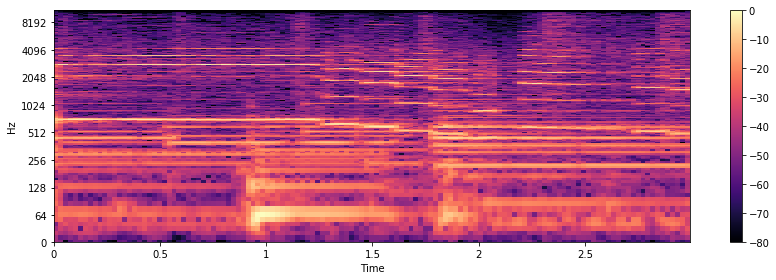

In [18]:
#Plot a 3-second slice of the spectrum
idx = slice(*librosa.time_to_frames([0, 3], sr=sr))
plt.figure(figsize=(12, 4))
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.colorbar()
plt.tight_layout()

In [19]:
# We'll compare frames using cosine similarity, and aggregate similar frames
# by taking their (per-frequency) median value.
#
# To avoid being biased by local continuity, we constrain similar frames to be
# separated by at least 2 seconds.
#
# This suppresses sparse/non-repetetitive deviations from the average spectrum,
# and works well to discard vocal elements.

S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr)))

# The output of the filter shouldn't be greater than the input
# if we assume signals are additive.  Taking the pointwise minimium
# with the input spectrum forces this.
S_filter = np.minimum(S_full, S_filter)

In [20]:
# We can also use a margin to reduce bleed between the vocals and instrumentation masks.
# Note: the margins need not be equal for foreground and background separation
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components

S_foreground = mask_v * S_full
S_background = mask_i * S_full

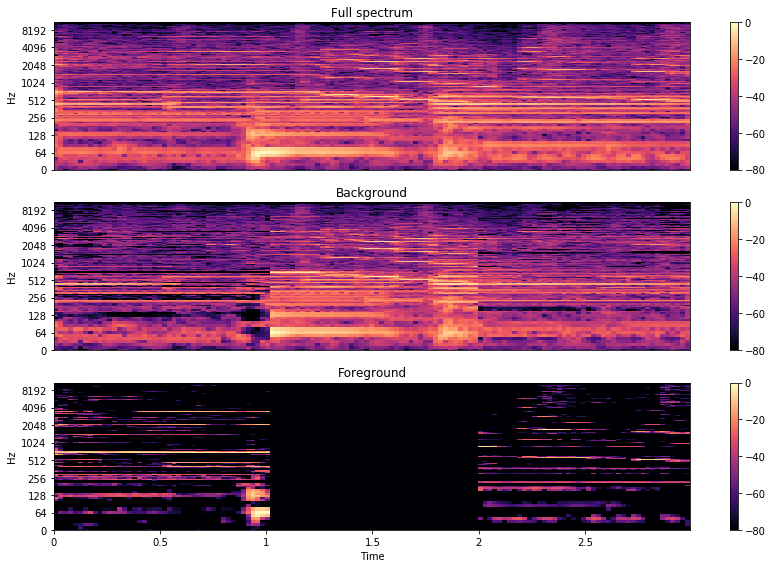

In [21]:
# sphinx_gallery_thumbnail_number = 2

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', sr=sr)
plt.title('Full spectrum')
plt.colorbar()

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S_background[:, idx], ref=np.max),
                         y_axis='log', sr=sr)
plt.title('Background')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(S_foreground[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('Foreground')
plt.colorbar()
plt.tight_layout()
plt.show()

# librosa.feature.mfcc

In [5]:
mfcc_matrix = librosa.feature.mfcc(y=y, sr=sr)

In [6]:
mfcc_matrix1 = librosa.feature.mfcc(y=y1, sr=sr1)

In [8]:
mfcc_matrix2 =  librosa.feature.mfcc(y2,sr2)

In [26]:
print(mfcc_matrix.shape)
print(mfcc_matrix)

(20, 130)
[[ -89.19490539  -99.59237284 -126.63367367 ... -126.13488059
  -121.56627583 -104.59067606]
 [ 105.87701171   89.99966344   64.03710412 ...   48.9871345
    58.68909782   71.50593466]
 [ -34.74444467  -20.93428394  -11.17338331 ...  -13.24236408
   -16.89300736  -25.90093192]
 ...
 [   6.53211489    6.52581149    4.77523238 ...  -11.07325766
   -13.29512286  -12.16523992]
 [  -3.24034555   -6.27396084   -6.98164718 ...   -6.71997763
   -10.28443292  -17.79314844]
 [  11.7258917    14.09110849   16.17880791 ...   14.9778092
     9.98684586   -0.13628643]]


In [9]:
print(mfcc_matrix2.shape)
print(mfcc_matrix2)

(20, 862)
[[-7.52064918e+01 -8.84292332e+01 -1.06511811e+02 ... -1.26362786e+02
  -1.30037783e+02 -9.39260812e+01]
 [ 4.63987585e+01  4.33301688e+01  3.41363019e+01 ...  1.13606666e+02
   1.22384928e+02  1.25569799e+02]
 [-5.93828720e+01 -4.67362433e+01 -3.35560347e+01 ... -4.24080775e+00
  -2.54206390e+01 -4.06118447e+01]
 ...
 [ 7.16380905e+00  4.43441323e+00 -1.54191384e+00 ...  8.30571078e+00
   2.05512072e+00  4.24891060e+00]
 [-2.82646983e+00 -4.05785670e+00 -6.96567020e+00 ...  1.24373226e+00
  -9.41932279e-03  2.75774649e+00]
 [-2.00028391e+00  2.11546759e+00  8.20600709e+00 ...  4.20285813e+00
  -4.21030937e+00 -1.03326897e+01]]


In [38]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
S_mfcc_matrix = librosa.feature.mfcc(S=librosa.power_to_db(S))
S1 = librosa.feature.melspectrogram(y=y1, sr=sr1, n_mels=128, fmax=8000)
S1_mfcc_matrix = librosa.feature.mfcc(S=librosa.power_to_db(S1))

In [28]:
print(S_mfcc_matrix.shape)
print(S_mfcc_matrix)

(20, 130)
[[ -64.24820334  -79.34027706 -111.79466988 ... -114.37130332
  -109.68629893  -90.73613191]
 [  80.05214446   67.63288372   44.68999379 ...   33.84113871
    44.43938344   56.68782917]
 [ -18.17047263   -3.27286799   11.5006215  ...    0.31198784
    -5.98147616  -17.04177717]
 ...
 [   7.74226357    8.27758803    8.13427808 ...    8.86151765
     3.34557785   -8.60870579]
 [  18.30742402   17.39692908   22.0164696  ...   15.51393697
    18.98606663   19.64037983]
 [   2.39841023    1.29703757    3.95324593 ...   -8.68749845
    -4.92747525   -1.76440561]]


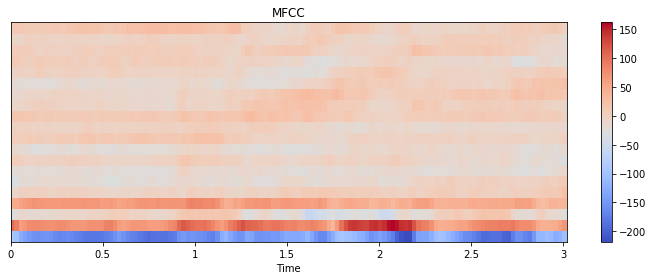

In [29]:
# Visualize the MFCC series
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc_matrix, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

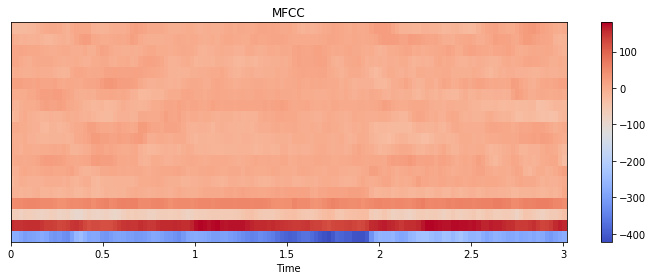

In [39]:
# Visualize the MFCC series
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc_matrix1, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

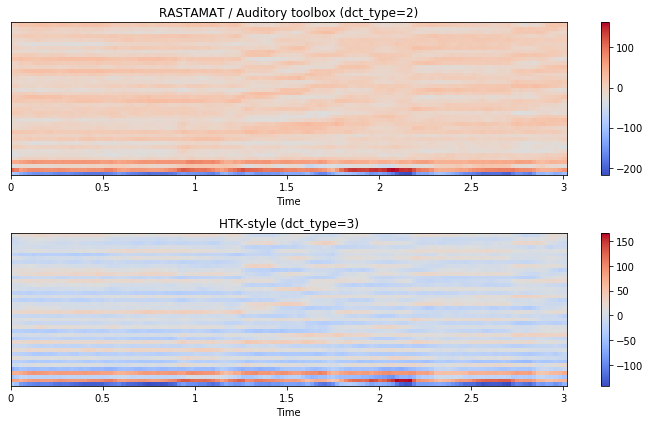

In [13]:
#Compare different DCT bases
m_slaney = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40, dct_type=2)
m_htk = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40, dct_type=3)
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
librosa.display.specshow(m_slaney, x_axis='time')
plt.title('RASTAMAT / Auditory toolbox (dct_type=2)')
plt.colorbar()
plt.subplot(2, 1, 2)
librosa.display.specshow(m_htk, x_axis='time')
plt.title('HTK-style (dct_type=3)')
plt.colorbar()
plt.tight_layout()

In [18]:
m_slaney

array([[ -89.19490539,  -99.59237284, -126.63367367, ..., -126.13488059,
        -121.56627583, -104.59067606],
       [ 105.87701171,   89.99966344,   64.03710412, ...,   48.9871345 ,
          58.68909782,   71.50593466],
       [ -34.74444467,  -20.93428394,  -11.17338331, ...,  -13.24236408,
         -16.89300736,  -25.90093192],
       ...,
       [ -10.78271251,   -9.30001222,   -3.55913929, ...,   -4.4484576 ,
          -8.75960243,  -10.88914231],
       [ -13.61511192,   -5.86765842,    2.34130495, ...,   13.74645105,
           3.75900034,    1.75456902],
       [   3.79585508,   10.14117684,   21.61791284, ...,   20.79646547,
          19.41364038,   13.66929896]])

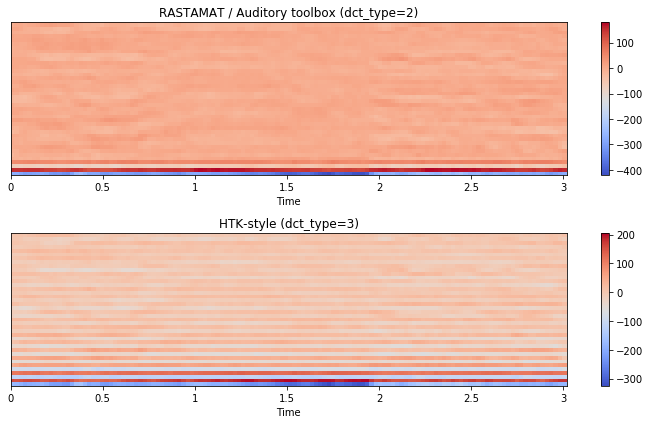

In [14]:
#Compare different DCT bases
m_slaney1 = librosa.feature.mfcc(y=y1, sr=sr1, n_mfcc=40, dct_type=2)
m_htk1 = librosa.feature.mfcc(y=y1, sr=sr1, n_mfcc=40, dct_type=3)
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
librosa.display.specshow(m_slaney1, x_axis='time')
plt.title('RASTAMAT / Auditory toolbox (dct_type=2)')
plt.colorbar()
plt.subplot(2, 1, 2)
librosa.display.specshow(m_htk1, x_axis='time')
plt.title('HTK-style (dct_type=3)')
plt.colorbar()
plt.tight_layout()